André Bamberg Pan, RA:2079844

In [145]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Normalização dos dados

In [167]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classificador LDA

In [168]:
class LDA:
    def fit(self, X, y):
        n_classes = len(np.unique(y))
        n_features = X.shape[1]

        self.class_means = np.zeros((n_classes, n_features))
        for c in range(n_classes):
            self.class_means[c, :] = np.mean(X[y == c], axis=0)

        overall_mean = np.mean(X, axis=0)
        between_class_scatter = np.zeros((n_features, n_features))
        within_class_scatter = np.zeros((n_features, n_features))

        for c in range(n_classes):
            n_samples_in_class = X[y == c].shape[0]
            diff = (self.class_means[c, :] - overall_mean).reshape(-1, 1)
            between_class_scatter += n_samples_in_class * diff @ diff.T

            class_mean_centered = (X[y == c] - self.class_means[c, :]).T
            within_class_scatter += class_mean_centered @ class_mean_centered.T

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(within_class_scatter) @ between_class_scatter)
        self.w = eigenvectors[:, np.argmax(eigenvalues)]

    def predict(self, X):
        y_pred = np.dot(X, self.w)
        return self._to_class_labels(y_pred)

    def _to_class_labels(self, y_pred):
        class_labels = np.zeros_like(y_pred, dtype=int)
        for i, pred in enumerate(y_pred):
            distances = np.linalg.norm(pred - self.class_means, axis=1)
            class_labels[i] = np.argmin(distances)
        return class_labels


In [169]:
lda = LDA()
lda.fit(X_train_scaled, y_train)

Teste de acurácia para treino e teste do LDA

In [170]:
y_pred_train_lda = lda.predict(X_train_scaled)
y_pred_test_lda = lda.predict(X_test_scaled)

accuracy_train_lda = accuracy_score(y_train, y_pred_train_lda)
accuracy_test_lda = accuracy_score(y_test, y_pred_test_lda)

print(f'Acurácia do LDA no conjunto de treino: {accuracy_train_lda:.2f}')
print(f'Acurácia do LDA no conjunto de teste: {accuracy_test_lda:.2f}')


Acurácia do LDA no conjunto de treino: 0.95
Acurácia do LDA no conjunto de teste: 0.93


Classificador QDA

In [171]:
class QDA:
    def fit(self, X, y):
        n_classes = len(np.unique(y))
        n_features = X.shape[1]

        self.class_means = np.zeros((n_classes, n_features))
        self.class_covs = []

        for c in range(n_classes):
            self.class_means[c, :] = np.mean(X[y == c], axis=0)
            self.class_covs.append(np.cov(X[y == c].T))

    def predict(self, X):
        n_classes = len(self.class_means)
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, n_classes))

        for c in range(n_classes):
            class_mean = self.class_means[c, :]
            class_cov = self.class_covs[c]

            diff = X - class_mean
            exponent = np.sum(np.dot(diff, np.linalg.inv(class_cov)) * diff, axis=1)

            predictions[:, c] = -0.5 * exponent - 0.5 * np.log(np.linalg.det(class_cov))

        return np.argmax(predictions, axis=1)


In [172]:
qda = QDA()
qda.fit(X_train_scaled, y_train)

Teste de acurácia para treino e teste do QDA

In [173]:
y_pred_train_qda = qda.predict(X_train_scaled)
y_pred_test_qda = qda.predict(X_test_scaled)

accuracy_train_qda = accuracy_score(y_train, y_pred_train_qda)
accuracy_test_qda = accuracy_score(y_test, y_pred_test_qda)

print(f'Acurácia do QDA no conjunto de treinamento: {accuracy_train_qda:.2f}')
print(f'Acurácia do QDA no conjunto de teste: {accuracy_test_qda:.2f}')

Acurácia do QDA no conjunto de treinamento: 0.96
Acurácia do QDA no conjunto de teste: 1.00


Visualização das fronteiras de decisões

In [174]:
def plot_decision_boundary(model, X, y, title):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('Petal Length')
    plt.ylabel('Petal Width')
    plt.title(title)
    plt.show()


LDA nos dados de treino

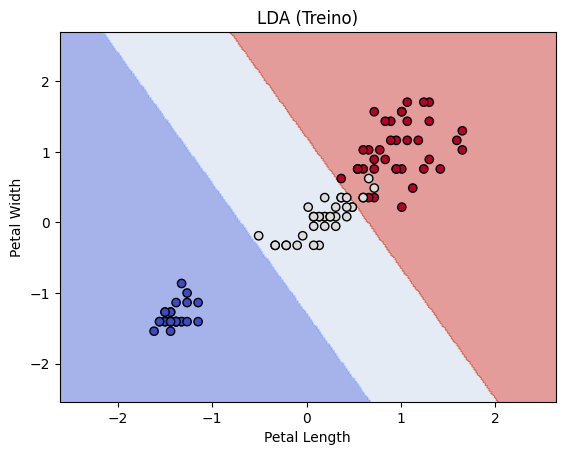

In [179]:
plot_decision_boundary(lda, X_train_scaled, y_train, 'LDA (Treino)')

LDA nos dados de teste

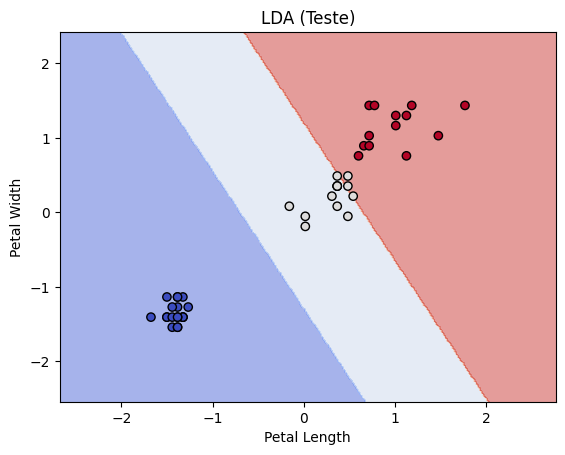

In [180]:
plot_decision_boundary(lda, X_test_scaled, y_test, 'LDA (Teste)')

QDA nos dados de treino

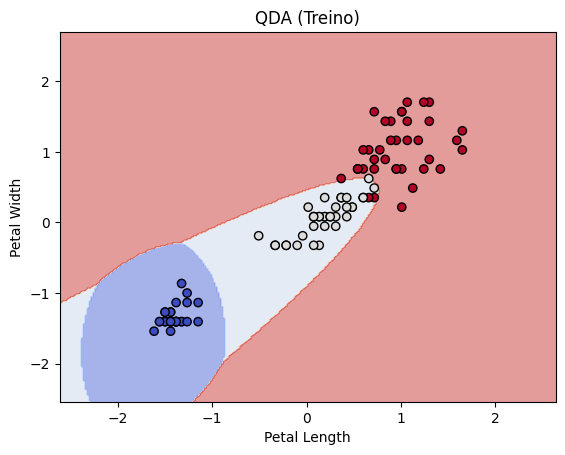

In [177]:
plot_decision_boundary(qda, X_train_scaled, y_train, 'QDA (Treino)')

QDA nos dados de teste

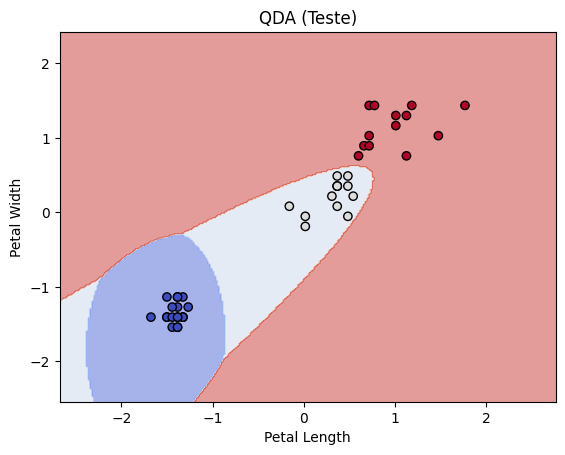

In [178]:
plot_decision_boundary(qda, X_test_scaled, y_test, 'QDA (Teste)')